In [5]:
import pandas as pd
import numpy as np


df = pd.read_csv("clickbait_dataset.csv")


df = df[["clickbait", "methods"]]


df["methods"] = df["methods"].apply(eval)


X_texts = df["clickbait"].tolist()
Y_labels = np.array(df["methods"].tolist())


print("Quantity of samples:", len(X_texts))
print("Sample text:", X_texts[0])
print("Example labels:", Y_labels[0])




Quantity of samples: 870
Sample text: You Won't Believe What Just Happened to Harvey Weinstein's 2020 Rape Conviction
Example labels: [1 0 0 0 0 0 0 0 0 0]


In [6]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_len = 64

tokenized = tokenizer(
    X_texts,
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_tensors='np'
)


print("input_ids shape:", tokenized['input_ids'].shape)
print("attention_mask shape:", tokenized['attention_mask'].shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

input_ids shape: (870, 64)
attention_mask shape: (870, 64)


In [7]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=10,
    problem_type="multi_label_classification"
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.model_selection import train_test_split

X_ids_train, X_ids_test, mask_train, mask_test, y_train, y_test = train_test_split(
    tokenized["input_ids"],
    tokenized["attention_mask"],
    Y_labels,
    test_size=0.2,
    random_state=42
)

X_ids_train = tf.convert_to_tensor(X_ids_train)
X_ids_test = tf.convert_to_tensor(X_ids_test)
mask_train = tf.convert_to_tensor(mask_train)
mask_test = tf.convert_to_tensor(mask_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)


history = model.fit(
    x={"input_ids": X_ids_train, "attention_mask": mask_train},
    y=y_train,
    validation_data=(
        {"input_ids": X_ids_test, "attention_mask": mask_test}, y_test
    ),
    epochs=3,
    batch_size=16
)


Epoch 1/3
44/44 [==============================] - 568s 12s/step - loss: 2.1951 - binary_accuracy: 0.6563 - precision: 0.3195 - recall: 0.1212 - val_loss: 1.5839 - val_binary_accuracy: 0.7086 - val_precision: 0.4423 - val_recall: 0.0459
Epoch 2/3
44/44 [==============================] - 527s 12s/step - loss: 1.8585 - binary_accuracy: 0.6796 - precision: 0.2828 - recall: 0.0390 - val_loss: 1.5756 - val_binary_accuracy: 0.7138 - val_precision: 0.6667 - val_recall: 0.0120
Epoch 3/3
44/44 [==============================] - 523s 12s/step - loss: 1.8374 - binary_accuracy: 0.6948 - precision: 0.4383 - recall: 0.0337 - val_loss: 1.5605 - val_binary_accuracy: 0.7132 - val_precision: 0.5714 - val_recall: 0.0160


In [9]:
from sklearn.metrics import classification_report
import numpy as np


y_probs = model.predict({"input_ids": X_ids_test, "attention_mask": mask_test}).logits


y_pred = (tf.sigmoid(y_probs).numpy() > 0.5).astype(int)


label_names = [
    "Curiosity Gap", "Exaggeration", "Emotional Triggers",
    "Sensationalism", "Lists/Superlatives", "Ambiguous References",
    "Direct Appeals", "Unfinished Narratives", "Unexpected Associations",
    "Provocative Questions"
]


print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))


6/6 [==============================] - 39s 6s/step
                         precision    recall  f1-score   support

          Curiosity Gap       0.32      1.00      0.48        54
           Exaggeration       0.26      1.00      0.42        46
     Emotional Triggers       0.31      1.00      0.47        54
         Sensationalism       0.00      0.00      0.00        45
     Lists/Superlatives       0.30      1.00      0.47        53
   Ambiguous References       0.00      0.00      0.00        42
         Direct Appeals       0.37      1.00      0.54        65
  Unfinished Narratives       0.00      0.00      0.00        43
Unexpected Associations       0.29      1.00      0.45        50
  Provocative Questions       0.30      1.00      0.46        49

              micro avg       0.31      0.74      0.43       501
              macro avg       0.22      0.70      0.33       501
           weighted avg       0.23      0.74      0.35       501
            samples avg       0.31   

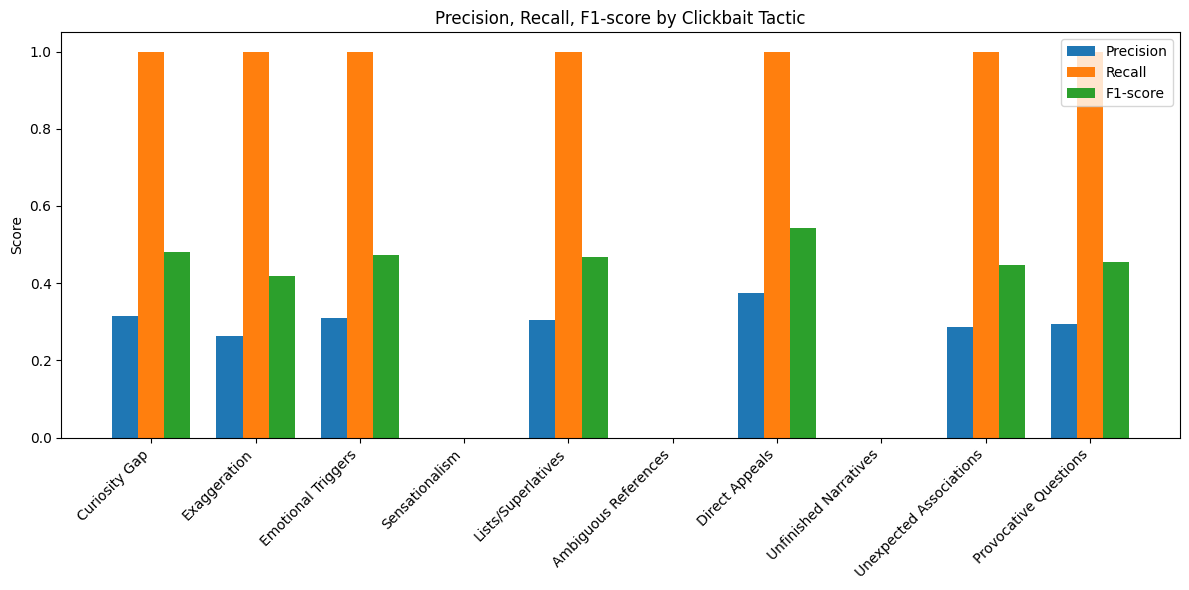

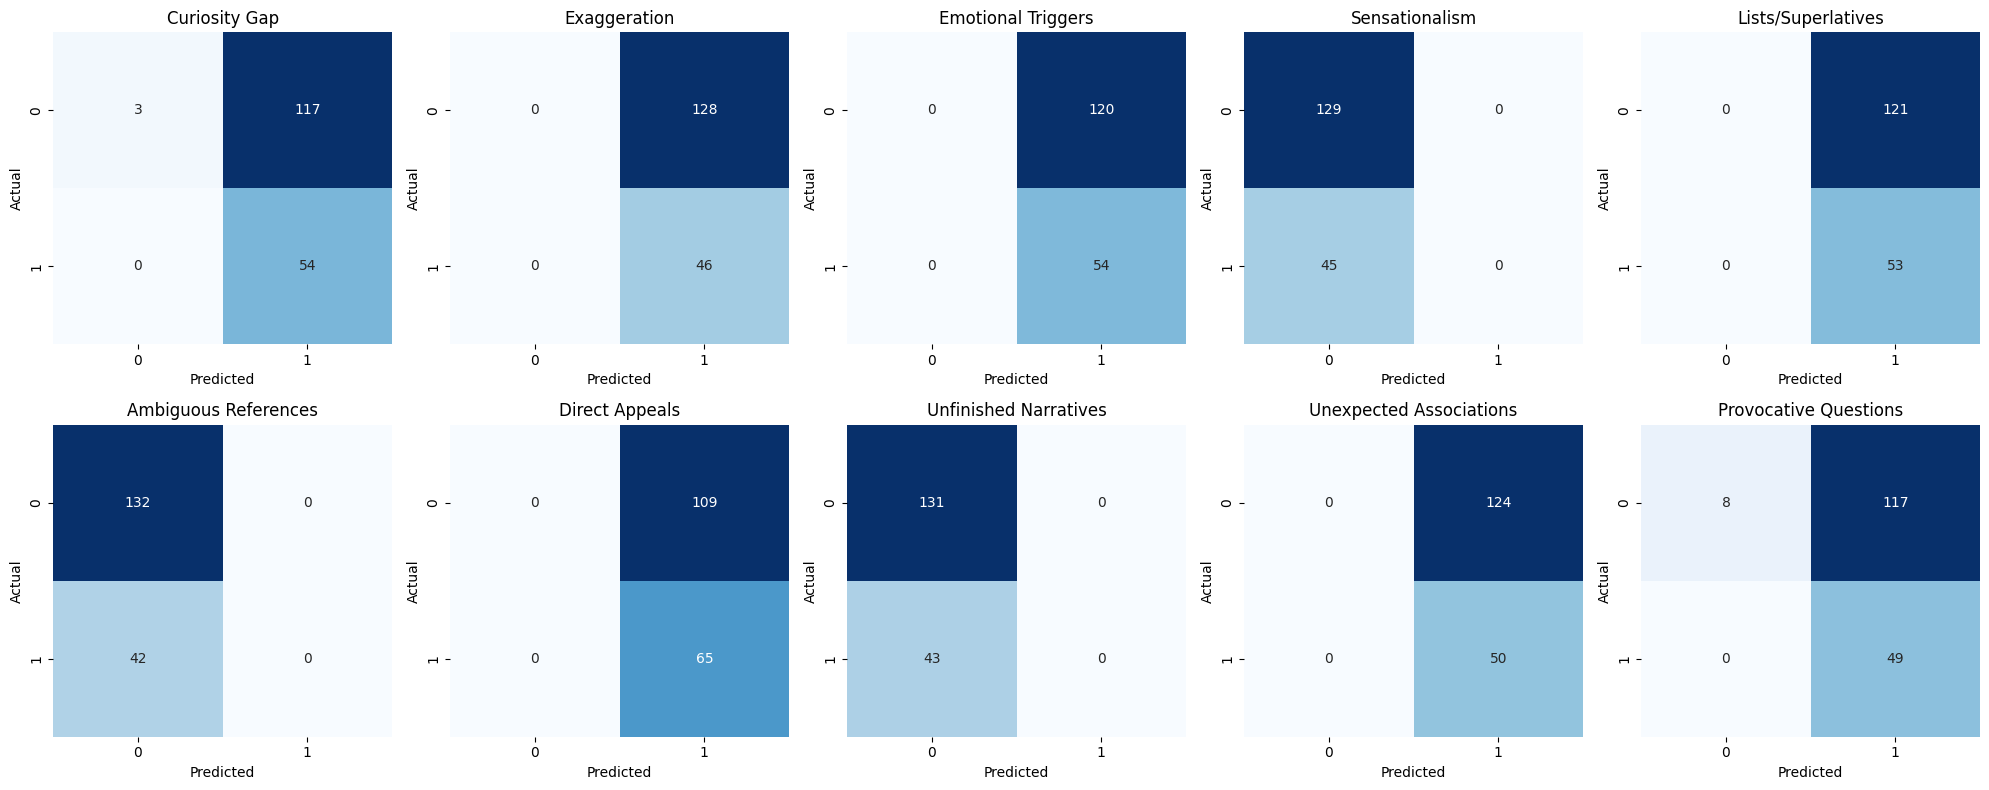

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support


labels = [
    "Curiosity Gap", "Exaggeration", "Emotional Triggers",
    "Sensationalism", "Lists/Superlatives", "Ambiguous References",
    "Direct Appeals", "Unfinished Narratives", "Unexpected Associations",
    "Provocative Questions"
]


precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0)


x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width=width, label='Precision')
plt.bar(x, recall, width=width, label='Recall')
plt.bar(x + width, f1, width=width, label='F1-score')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score by Clickbait Tactic")
plt.legend()
plt.tight_layout()
plt.show()


mcm = multilabel_confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(labels[i])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [11]:
# Improving a multi-label model for detecting clickbait tactics with RoBERTa, Augmentation, and an adjusted threshold

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_fscore_support
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
import random


METHODS_CATALOG = [
    "Curiosity Gap", "Exaggeration", "Emotional Triggers",
    "Sensationalism", "Lists/Superlatives", "Ambiguous References",
    "Direct Appeals", "Unfinished Narratives", "Unexpected Associations",
    "Provocative Questions"
]

df = pd.read_csv("clickbait_dataset.csv")
df["methods"] = df["methods"].apply(eval)


def augment_text(text):
    variants = [
        text.upper(),
        text.replace("the", "THE"),
        text.replace("!", "!!!"),
        text + " (You won’t believe this!)",
        text.replace("This", "Guess What")
    ]
    return random.choice(variants)

augmented = df.copy()
augmented["clickbait"] = augmented["clickbait"].apply(augment_text)

df_all = pd.concat([df, augmented]).sample(frac=1, random_state=42).reset_index(drop=True)

X_texts = df_all["clickbait"].tolist()
Y_labels = np.array(df_all["methods"].tolist())


tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_len = 64
tokenized = tokenizer(
    X_texts,
    max_length=max_len,
    padding='max_length',
    truncation=True,
    return_tensors='np'
)

\
X_ids_train, X_ids_test, mask_train, mask_test, y_train, y_test = train_test_split(
    tokenized["input_ids"],
    tokenized["attention_mask"],
    Y_labels,
    test_size=0.2,
    random_state=42
)

X_ids_train = tf.convert_to_tensor(X_ids_train)
X_ids_test = tf.convert_to_tensor(X_ids_test)
mask_train = tf.convert_to_tensor(mask_train)
mask_test = tf.convert_to_tensor(mask_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)


model = TFRobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=10, problem_type="multi_label_classification")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


history = model.fit(
    x={"input_ids": X_ids_train, "attention_mask": mask_train},
    y=y_train,
    validation_data=({"input_ids": X_ids_test, "attention_mask": mask_test}, y_test),
    epochs=3,
    batch_size=16
)


logits = model.predict({"input_ids": X_ids_test, "attention_mask": mask_test}).logits
y_probs = tf.sigmoid(logits).numpy()


thresholds = []
for i in range(10):
    fpr, tpr, thresh = roc_curve(y_test[:, i], y_probs[:, i])
    best_thresh = thresh[np.argmax(tpr - fpr)]
    thresholds.append(best_thresh)


y_pred = np.array([[(1 if prob > thresholds[i] else 0) for i, prob in enumerate(sample)] for sample in y_probs])


print(classification_report(y_test, y_pred, target_names=METHODS_CATALOG, zero_division=0))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/3
87/87 [==============================] - 1090s 12s/step - loss: 0.8541 - binary_accuracy: 0.6843 - precision_1: 0.2865 - recall_1: 0.0352 - val_loss: 0.5998 - val_binary_accuracy: 0.7026 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/3
87/87 [==============================] - 1069s 12s/step - loss: 0.6003 - binary_accuracy: 0.6989 - precision_1: 0.4888 - recall_1: 0.0891 - val_loss: 0.5373 - val_binary_accuracy: 0.7276 - val_precision_1: 0.7514 - val_recall_1: 0.1256
Epoch 3/3
11/11 [==============================] - 72s 6s/step
                         precision    recall  f1-score   support

          Curiosity Gap       0.48      0.80      0.60       121
           Exaggeration       0.72      0.63      0.67       109
     Emotional Triggers       0.45      0.75      0.57       109
         Sensationalism       0.41      0.65      0.50        95
     Lists/Superlatives       0.89      0.93      0.91       100
   Ambiguous References       0.58      0.45  

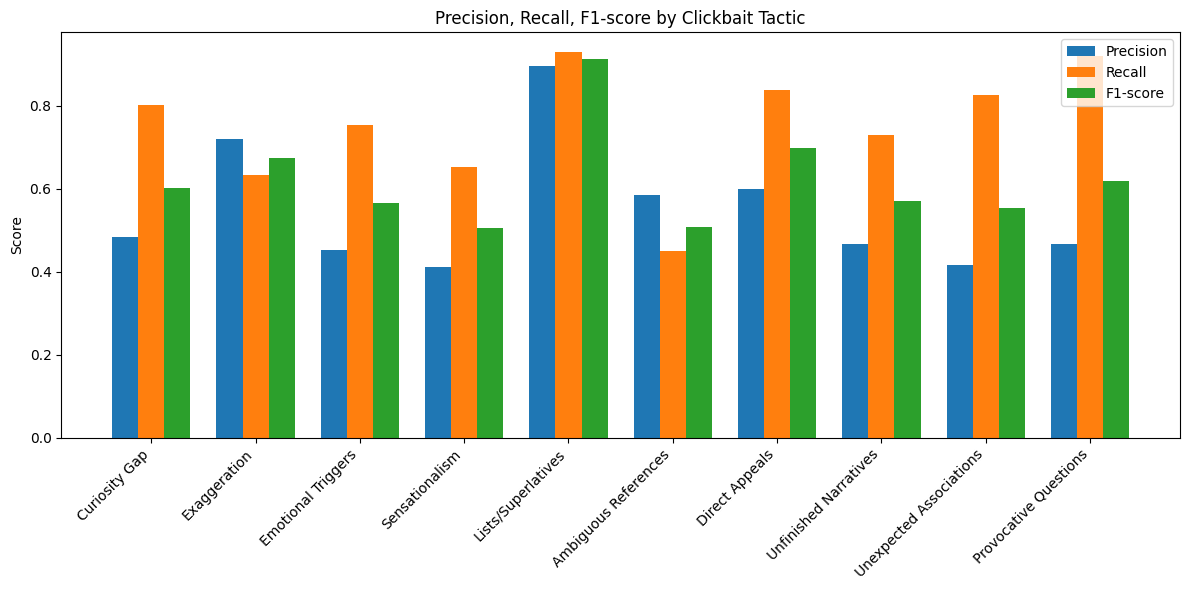

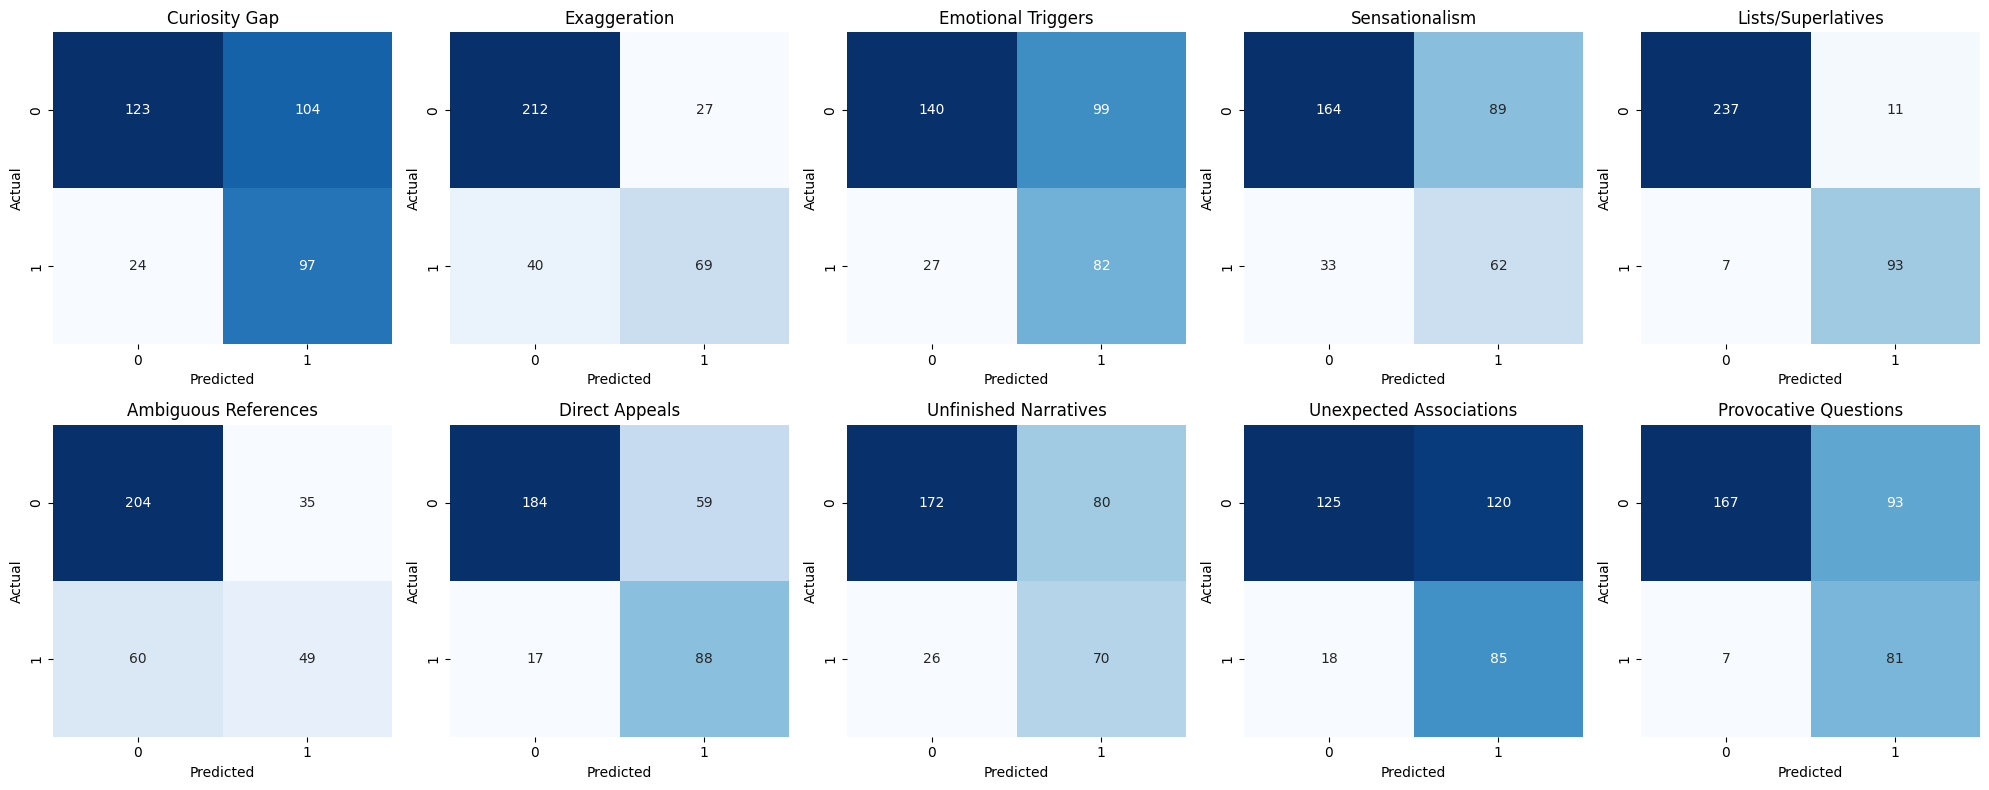

In [12]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0)


x = np.arange(len(METHODS_CATALOG))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width=width, label='Precision')
plt.bar(x, recall, width=width, label='Recall')
plt.bar(x + width, f1, width=width, label='F1-score')
plt.xticks(x, METHODS_CATALOG, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score by Clickbait Tactic")
plt.legend()
plt.tight_layout()
plt.show()


mcm = multilabel_confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(METHODS_CATALOG[i])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()
